# Proximal Policy Optimization

Today we look at one of the most popular RL techniques: Proximal Policy Optimization. A soft pre-req to this is the [Trust Region Policy Optimization (TRPO)](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/Trust%20Region%20Policy%20Optimization/trpo.ipynb) method but its ok if you dont have that. TRPO is a notoriously difficult to understand and difficult to implement architecture. It probably isn't a good place for a beginner to start! So I will give a quick primer on TRPO without explaining any details first. What you should definitely know as of now is [REINFORCE](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/Policy%20Networks%20(REINFORCE)/policy_networks.ipynb), [REINFORCE w/ Baseline](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/REINFORCE%20with%20Baseline/reinforce_with_baseline.ipynb), [Actor Critic](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/Vanilla%20Actor%20Critic/actor_critic.ipynb), and hopefully [GAE](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/Generalized%20Advantage%20Estimate/generalized_advantage_estimation.ipynb) as these are necessary prereqs.

## Policy Optimization Recap

Our loss function that we derived for our Policy Gradient was:

$$\nabla_\theta J(\theta) \propto E_{\pi} \left[\Psi\nabla_\theta \ln\pi_\theta(a|s)\right]$$

Where $\Psi$ can be all sorts of stuff, like Monte Carlo returns, TD(0) estimates, Advantage, and others! The main goal of our Policy Gradient method is to learn a policy $\pi(a|s)$ that can tell us the best action to take at a state. This is different from the previous value-based methods where were weren't directly optimizing the Policy, but rather optimizing the Value function $Q(s,a)$ and then deriving the policy from that! Here is a great figure from [GAE](https://arxiv.org/abs/1506.02438) showing this!

<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/Generalized%20Advantage%20Estimate/src/gae_paper_fig.png?raw=true" alt="drawing" width="600"/>

### Problem

Unfortunately, if our entire decision making is dependent on this policy model $\pi$, this can lead to poor training stability. As our model updates, it can have large fluctuations in what it thinks the ideal action should be, so we need a way to reign this in. Therefore, what we need is something like a regularization technique, that avoids parameter updates that change the policy too much. 

## Trust Region Policy Optimzation TLDR

$$L(\theta_k, \theta) = E_{s,a\sim\pi_{\theta_k}}\left[\frac{\pi_\theta(a|s)}{\pi_{\theta_k}(a|s)}A_{\pi_{\theta_k}}(s,a)\right]$$
$$\text{s.t. } D_{KL}(\theta||\theta_k) < \delta$$

### KL Divergence 
If our goal is to limit large changes between our policy updates, why not regularize that? Policies are just distributions over the actions you can take at a specific state. This means we can use a metric like KL-Divergence to measure the "Distance" between the our policies, and we can ensure our model doesn't allow this distance to get too large! 

For discrete action spaces, the KL-Divergence is:
$$D_{\text{KL}}(\pi_1 \| \pi_2) = \sum_{a} \pi_1(a|s) \log \left( \frac{\pi_1(a|s)}{\pi_2(a|s)} \right)$$

Therefore our goal is to ensure that whenever we train our policy, that don't allow the KL divergence between the new and old policy to exceed some (hard) threshold that we call $\delta$!

### Importance Sampling

Here is an other problem. When we collect our experiences as we interact with the environment, that will be done with our current policy. But when we update our policy, we need to have an estimate for the action distribution that **NEW** policy would have given us in that same situation as the old policy. This is exactly what Importance Sampling enables. 

Incase you don't remember, the main idea is that sometimes we want to convert densities between distributions. In our case our advantages $A_{\pi_{\theta_k}}(s,a)$ was taken from the distribution $\pi_{\theta_k}$ (as that is the policy we used when playing the game), but we want to estimate $\pi_\theta$, Therefore, what if we scaled our $A_{\pi_{\theta_k}}(s,a)$, dividing by our $\pi_{\theta_k}$ and multiplying by $\pi_\theta$. This is effectively converting our advantage results from our original distribution to our new one!

$$\text{Importance Sampling} = \frac{\pi_\theta(a|s)}{\pi_{\theta_k}(a|s)}A_{\pi_{\theta_k}}(s,a)$$

### Optimization

We are dealing with a constrained optimization problem, and training this is pretty complicated as there is a lot going on. The thing is that, although we have our loss function above, that actually isn't easily computable. Therefore we use 2nd order approximations (Taylor Series) to have our best guess at the functions. We can then show we can solve the optimization problem using **Conjugate Gradients** and **LineSearch**. Please take a look at the [TRPO Notebook](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/Trust%20Region%20Policy%20Optimization/trpo.ipynb) if you want to see the math that goes into this, but I wont go much more into it here!


### Takeaway

Constrained optimization is hard! And it forces us to use a lot of tricks to actually solve it, all of which makes computation inefficient. So instead of enforcing some hard constraint, on the KL Divergence, what if we just use a simple **Clipped Objective**  to avoid actually needing to do all the fancy math for the constrained optimization? This is exactly PPO!

## PPO Clipped Surrogate Objective

There are actually a few variants of PPO that exist, but lets just talk about the most basic one first, as all other are just minor changes. PPO is still solving the same problem using Importance Sampling as TRPO, so we can start with:

$$L(\theta) = E\left[\frac{\pi_\theta(a|s)}{\pi_{\theta_{old}}(a|s)}A_{\pi_{\theta_{old}}}(s,a)\right]$$

And where TRPO used a hard constraint of $\delta$ for the KL divergence, PPO yses a clipped objective that looks like:

$$L^{\text{CLIP}} = E[\min(r_t(\theta)A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)A_t)]$$

where $r_t(\theta)$ is just our ratio of our new and old policies!

$$r_t(\theta) = \frac{\pi_\theta(a|s)}{\pi_{\theta_{old}}(a|s)}$$

##### Lets pull this apart:

First compute our surrogate objective like normal:

$$\text{Surrogate Objective} = \frac{\pi_\theta(a|s)}{\pi_{\theta_{old}}(a|s)}A_t$$

Next clip our ratio between $1-\epsilon, 1+\epsilon$ where $\epsilon$ is a hyperparameter (how restrictive do you want to be?). Remember, the closer we are to 1, the more similar our two policies are! This makes sure that if the ratio goes too far away from 1 (very different policies) we limit its effect. 

$$\text{Clipped Ratio} = \text{clip}\left(\frac{\pi_\theta(a|s)}{\pi_{\theta_{old}}(a|s)}, 1-\epsilon, 1+\epsilon\right)$$

Compute the Surrogate Objective on the Clipped Ratio:

$$\text{Clipped Surrogate Objective} = \text{Clipped Ratio} * A_t$$

And then check which is smaller!

$$\min(\text{Surrogate Objective}, \text{Clipped Surrogate Objective})$$

Taking the $\min$ is like saying, taking the more conservative policy. We want to ensure that we are increasing the probability of actions with positive advantages in our model, but only so much, as we are trying to avoid large changes. PPO attains this through a soft restriction rather than the hard $\delta$ restraint of TRPO. Lets quickly plot it!


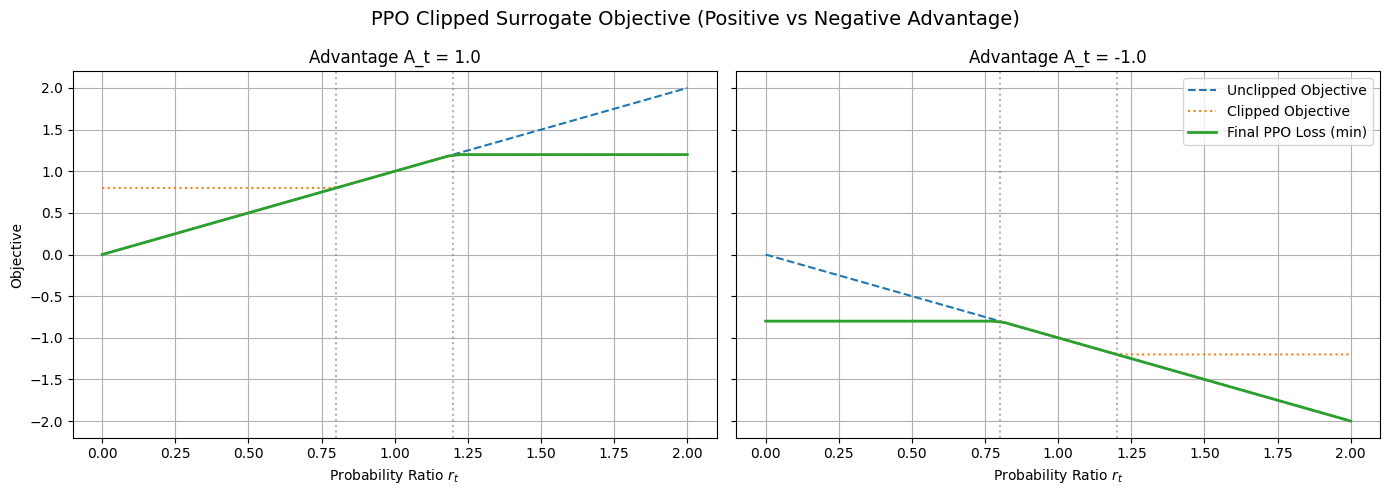

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set up
epsilon = 0.2
r = np.linspace(0, 2, 50)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

for i, A_t in enumerate([1.0, -1.0]):
    unclipped = r * A_t
    clipped = np.clip(r, 1 - epsilon, 1 + epsilon) * A_t
    ppo_loss = np.minimum(unclipped, clipped)

    ax = axes[i]
    ax.plot(r, unclipped, label='Unclipped Objective', linestyle='--')
    ax.plot(r, clipped, label='Clipped Objective', linestyle=':')
    ax.plot(r, ppo_loss, label='Final PPO Loss (min)', linewidth=2)

    ax.axvline(1 - epsilon, color='gray', linestyle=':', alpha=0.6)
    ax.axvline(1 + epsilon, color='gray', linestyle=':', alpha=0.6)
    ax.set_title(f'Advantage A_t = {A_t}')
    ax.set_xlabel('Probability Ratio $r_t$')
    ax.grid(True)

axes[0].set_ylabel('Objective')
axes[1].legend()
fig.suptitle('PPO Clipped Surrogate Objective (Positive vs Negative Advantage)', fontsize=14)
plt.tight_layout()
plt.show()

#### Positive Advantage

When we have a positive advantage, we want to assign more probability to that action! But if we did this the normal way, the model would assign a large loss value that would push the parameters towards this large change. Instead, we add this clip. Any ratio outside of 0.2 around the center of 1 doesn't change the effect (i.e. higher ratios are not interpreted to push for more change as we clipped it). This means the model will push the probability of an action even with very high advantages and high ratios more gently, keeping a soft constraint from changing our policies too much. 

#### Negative Advantage

Same idea! If an action has very low advantage at a state, the traditional loss would assign large gradients to update the parameters to ensure we reduce the probability of that action drastically. We again incorporate a soft constraint, ensuring that any ratio outside of our range is negated and we more gently update our policy. 

#### Minimum

By taking the min of our original objective and the clipped objective, we are basically staying on the safe side. The goal is to take the smallest perturbation possible.

## Lets Implement It!

As you will see, this implementation is going to be way more simple compared to TRPO! Mainly because we can use regular backprop and regular optimizers and not have to worry about manually doing gradients, or using fancy methods like Conjugate Gradients/LineSearch to do it! This should look very similar to the TRPO implementation, we are just tossing out all off the complex stuff!

### Implement The Models

The models are the same as before!

In [2]:
import argparse
import gymnasium as gym
import numpy as np
import scipy.optimize
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

class ActorPolicyNetwork(nn.Module):
    def __init__(self,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128):
        
        super(ActorPolicyNetwork, self).__init__()

        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        pi = F.softmax(self.fc3(x), dim=-1)
        return pi

class CriticValueNetwork(nn.Module):
    def __init__(self, input_state_features=8, hidden_features=128):
        super(CriticValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, 1)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

### Replay Buffer

To store memories is almost the same as before as well! But now we also need to hold onto the old probabilities for the different actions (basically when we played the game our policy at that time had some probabilities, hold onto them). We will need these later for our PPO loss to compute the ratio of our new to old probabilities.

In [3]:
class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.dones = []
        self.next_states = []
        self.rewards = []
        self.probs = []

    def store(self, state, action, done, next_state, reward, prob):
        self.states.append(state)
        self.actions.append(action)
        self.dones.append(0 if done else 1)
        self.next_states.append(next_state)
        self.rewards.append(reward)
        self.probs.append(prob)

    def reset(self):
        self.states = []
        self.actions = []
        self.dones = []
        self.next_states = []
        self.rewards = []
        self.probs = []
        
    def sample(self):
        return (np.array(self.states, dtype=np.float32),
                np.array(self.actions),
                np.array(self.dones, dtype=np.float32),
                np.array(self.next_states, dtype=np.float32),
                np.array(self.rewards, dtype=np.float32),
                np.array(self.probs, dtype=np.float32))


### Trainer

We can jump straight to training now! There is no more setup for Conjugate Gradients, LinearSearching and everthing else! The main changes are:

- Dont use ```BFGS``` to update Value network, just stick to Adam
- Add in the Clipped PPO Loss computation
- Use GAE to estimate our Advantages
- Train on batches of experience tuples (we could have done this in TRPO as well, I am just trying to show some different ways of doing the same thing!). Basically, what if you collected so much data from your environment that you cannot pass it all into your GPU (imagine your states being more complicated like images). In this case its important to train on your collected experiences in batches.

In [4]:
class Trainer:
    def __init__(self, 
                 env,
                 num_training_iterations=250,
                 gamma=0.995, 
                 lambda_weight=0.99, 
                 weight_decay=0.001, 
                 clip_eps=0.2, 
                 ppo_epochs=10,
                 mini_batch_size=64,
                 policy_lr=3e-4,
                 value_lr=3e-4,
                 batch_size=30_000,
                 print_freq=10, 
                 running_avg_scores=25,
                 target_rewards=200,
                 device="cpu"):

        self.env = env
        self.iterations = num_training_iterations
        self.gamma = gamma
        self.lmbda = lambda_weight
        self.weight_decay = weight_decay
        self.clip_eps = clip_eps
        self.ppo_epochs = ppo_epochs
        self.mini_batch_size = mini_batch_size
        self.batch_size = batch_size
        self.print_freq = print_freq
        self.target_rewards = target_rewards
        self.running_avg_scores = running_avg_scores
        self.device = device

        self.num_inputs = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        
        self.policy_network = ActorPolicyNetwork(self.num_inputs, self.num_actions).to(device)
        self.value_network = CriticValueNetwork(self.num_inputs).to(device)

        self.policy_optimizer = torch.optim.AdamW(self.policy_network.parameters(), lr=policy_lr, weight_decay=weight_decay)
        self.value_optimizer = torch.optim.AdamW(self.value_network.parameters(), lr=value_lr, weight_decay=weight_decay)

    def select_action(self, state):
        state = torch.from_numpy(state).unsqueeze(0).to(device=self.device, dtype=torch.float32)
        probs = self.policy_network(state)
        action = torch.multinomial(probs, 1)

        ### Grab the probability of the action we took ###
        prob = probs[0, action.item()].detach() 
        
        return action.item(), prob

    def get_ppo_loss(self, states, actions, advantages, old_probs):

        ### Get Action Probabilities ###
        action_probs = self.policy_network(states)

        ### Get the probs of the actions actually taken ###
        new_probs = action_probs.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        ### Compute probability ratio ###
        ratio = new_probs / (old_probs + 1e-8)  
        
        ### PPO clipped objective ###
        surrogate_loss = ratio * advantages
        clipped_surrogate_loss = torch.clamp(ratio, 1.0 - self.clip_eps, 1.0 + self.clip_eps) * advantages
        policy_loss = -torch.min(surrogate_loss, clipped_surrogate_loss).mean()
        
        return policy_loss

    def update_model(self, batch):
        states, actions, dones, next_states, rewards, old_probs = batch
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.long, device=self.device)
        states = torch.tensor(states, dtype=torch.float32, device=self.device)
        old_probs = torch.tensor(old_probs, dtype=torch.float32, device=self.device)

        values = self.value_network(states)
        returns = torch.zeros_like(values)
        advantages = torch.zeros_like(values)
        
        episode_ends = [i for i in range(len(dones)) if dones[i] == 0] + [len(dones)]
        episode_starts = [0] + [i+1 for i in episode_ends[:-1]]

        for start, end in zip(episode_starts, episode_ends):
            episode_rewards = rewards[start:end]
            episode_dones = dones[start:end]
            episode_values = values[start:end]

            future_rewards = 0
            future_values = 0
            future_advantages = 0
            
            for i in reversed(range(len(episode_rewards))):
                idx = start + i
                returns[idx] = episode_rewards[i] + self.gamma * future_rewards * episode_dones[i]
                td_error = episode_rewards[i] + self.gamma * future_values * episode_dones[i] - episode_values[i]
                advantages[idx] = td_error + self.gamma * self.lmbda * future_advantages * episode_dones[i]
                future_rewards = returns[idx]
                future_values = episode_values[i]
                future_advantages = advantages[idx]

        advantages = ((advantages - advantages.mean()) / (advantages.std() + 1e-8)).detach()

        ### TRAIN ON DATA IN BATCHES ###
        dataset_size = len(states)
        indices = np.arange(dataset_size)

        ### How Many Epochs on Each Set of Collected Memories? ###
        for epoch in tqdm(range(self.ppo_epochs), unit="epoch", leave=False):

            ### Shuffle Data Every Time ###
            np.random.shuffle(indices)

            ### Loop through data in batch_size intervals ###
            for start in range(0, dataset_size, self.mini_batch_size):

                ### Get ending index ###
                end = start + self.mini_batch_size

                ### Get random indicies for that batch ###
                sampled_indices = indices[start:end]

                ### Grab data from our memories at those random indices ###
                sampled_states = states[sampled_indices]
                sampled_actions = actions[sampled_indices]
                sampled_advantages = advantages[sampled_indices]
                sampled_returns = returns[sampled_indices]
                sampled_old_probs = old_probs[sampled_indices]
                
                ### Update policy network ###
                self.policy_optimizer.zero_grad()
                policy_loss = self.get_ppo_loss(sampled_states, sampled_actions, sampled_advantages, sampled_old_probs)
                policy_loss.backward()
                self.policy_optimizer.step()
                
                ### Update value network ###
                self.value_optimizer.zero_grad()
                sampled_values = self.value_network(sampled_states)
                value_loss = ((sampled_values - sampled_returns) ** 2).mean()
                value_loss.backward()
                self.value_optimizer.step()

    def train(self):
        
        memory = Memory()
        
        log = {"scores": [], "running_avg_scores": []}

        for i in range(self.iterations):
            num_episodes = 0
            total_reward = 0
            num_steps = 0

            with tqdm(total=self.batch_size, desc=f"Iter {i+1} Data Collection", unit="step", leave=False) as collector_bar:
                while num_steps <= self.batch_size:
                    state, _ = self.env.reset()
                    done = False
                    episode_score = 0
                    episode_steps = 0
    
                    while not done:
                        action, prob = self.select_action(state)
                        next_state, reward, terminal, truncate, _ = self.env.step(action)
                        done = terminal or truncate
                        
                        episode_steps += 1
                        episode_score += reward
    
                        memory.store(state, action, done, next_state, reward, prob.cpu().detach().numpy())
                        state = next_state
                        collector_bar.update(1)
    
                    total_reward += episode_score
                    num_steps += episode_steps 
                    num_episodes += 1
                    log["scores"].append(episode_score)
                    log["running_avg_scores"].append(np.mean(log["scores"][-self.running_avg_scores:]))
        
            total_reward = total_reward / num_episodes
            batch = memory.sample()
            self.update_model(batch)
            memory.reset()

            if i % self.print_freq == 0:
                print(f'Episode {i}, Avg Batch Rewards: {total_reward:.2f}')
                
            if total_reward > self.target_rewards:
                print(f"Achieved Reward {total_reward}, Completed Training!")
                break

        return self.policy_network, self.value_network, log

env = gym.make("LunarLander-v3")
print("TRAINING PPO")
trainer = Trainer(env, device="cuda")
policy, value, log = trainer.train()

TRAINING PPO


Iter 1 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Episode 0, Avg Batch Rewards: -184.26


Iter 2 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 3 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 4 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 5 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 6 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 7 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 8 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 9 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 10 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 11 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Episode 10, Avg Batch Rewards: -75.28


Iter 12 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 13 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 14 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 15 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 16 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 17 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 18 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 19 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 20 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 21 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Episode 20, Avg Batch Rewards: -1.73


Iter 22 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 23 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 24 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 25 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 26 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 27 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 28 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 29 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 30 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 31 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Episode 30, Avg Batch Rewards: 52.64


Iter 32 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 33 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 34 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 35 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 36 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 37 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 38 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 39 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 40 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 41 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Episode 40, Avg Batch Rewards: 114.93


Iter 42 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 43 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 44 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 45 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 46 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 47 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 48 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 49 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 50 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 51 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Episode 50, Avg Batch Rewards: 118.85


Iter 52 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 53 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 54 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 55 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 56 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 57 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 58 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 59 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 60 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 61 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Episode 60, Avg Batch Rewards: 131.92


Iter 62 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 63 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 64 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 65 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 66 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 67 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 68 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 69 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 70 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 71 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Episode 70, Avg Batch Rewards: 134.41


Iter 72 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 73 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 74 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 75 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 76 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 77 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 78 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 79 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 80 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 81 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Episode 80, Avg Batch Rewards: 137.08


Iter 82 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 83 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 84 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 85 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 86 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 87 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 88 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 89 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 90 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 91 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Episode 90, Avg Batch Rewards: 150.86


Iter 92 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 93 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 94 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 95 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 96 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 97 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 98 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 99 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 100 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 101 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Episode 100, Avg Batch Rewards: 162.03


Iter 102 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 103 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 104 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 105 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 106 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 107 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 108 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 109 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Iter 110 Data Collection:   0%|          | 0/30000 [00:00<?, ?step/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

Achieved Reward 207.4373032443866, Completed Training!


### Results

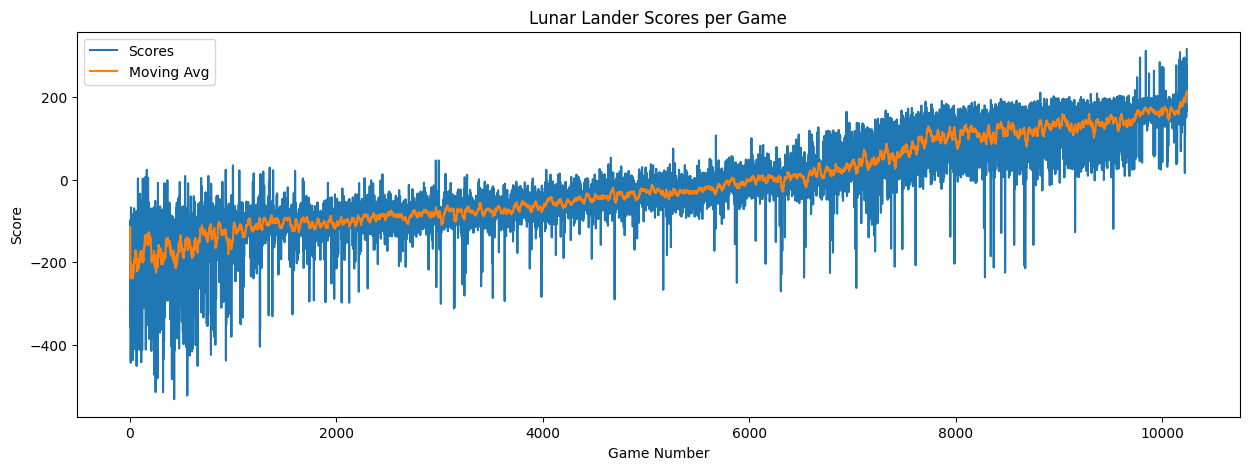

In [5]:
plt.figure(figsize=(15,5))
plt.plot(log["scores"], label="Scores")
plt.plot(log["running_avg_scores"], label="Moving Avg")
plt.title("Lunar Lander Scores per Game")
plt.xlabel("Game Number")
plt.ylabel("Score")
plt.legend()
plt.show()

### Play A Game!

In [7]:
from IPython.display import Video
def record_game(env, policy, prefix, device="cuda"):

    env = gym.wrappers.RecordVideo(env, 
                                   video_folder="./savevideos", 
                                   video_length=0, 
                                   disable_logger=True,
                                   name_prefix=prefix)

    done = False
    state, _ = env.reset()
    
    while not done:

        ### Get Predicted Action ###
        action = policy(torch.tensor(state, device=device).unsqueeze(0)).argmax(axis=-1).item()

        ### Step in Environment ###
        new_state, reward, terminal, truncate, _ = env.step(action)
        done = terminal or truncate 
        
        ### State is our New State ###
        state = new_state
        
    env.close()

env = gym.make("LunarLander-v3", render_mode="rgb_array")
record_game(env, policy, prefix="policy-network")

Video("savevideos/policy-network-episode-0.mp4", embed=True)

/home/priyam/anaconda3/envs/torch/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /mnt/analysisdrive/analysis/NCSA_HAL_Tutorials/PyTorch for Reinforcement Learning/Deep RL Policy Models/Proximal Policy Optimization/savevideos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


## PPO with KL Penalty

There is another way we could reasonably constraint our optimization, and thats by using our KL penalty!

### Thats It!

We have finally made it to PPO! Everything after is just for extra credit, but you mostly have everything you need now to understand RL for Large Language Models! 